# Discriminator Model for Off Label Generative Model

Given that transferring label functions doesn't improve performance, this notebook is designed to confirm that training a discriminator model on labels from a off-relation trained generative model would **fail** to increase predictive performance. Generative model here was trained using Compound treats Disease label functions and the discrimintator model is designed to predict Disease associates Gene sentences. Performance is reported in area under the receiver operating curve (AUROC) and area under the precision recall curve (AUPR).

In [1]:
import glob
import os
import pandas as pd

import seaborn as sns
from sklearn.metrics import auc, precision_recall_curve, roc_curve

# Tune Set

In [3]:
dev_labels = pd.read_csv("input/dag_dev_labels.tsv", sep="\t")
dev_labels.head()

,candidate_id,curated_dsh
0,21841,1.0
1,82680,0.0
2,177856,1.0
3,228511,1.0
4,235056,1.0


In [4]:
candidate_df = (
    pd.read_excel("../data/sentences/sentence_labels_dev.xlsx")
    .sort_values("candidate_id")
    .query("curated_dsh.notnull()")
)
candidate_df.head()

,candidate_id,disease,gene,doid_id,entrez_gene_id,sentence_id,sentence,curated_dsh,notes_dsh,curated_dug,notes_dug,curated_ddg,notes_ddg,Unnamed: 13
510,21841,hypertension,beta-hydroxylase,DOID:10763,1621,482597,the decrease of sympathetic activity by the be...,1.0,NaN,0.0,NaN,0.0,The drug decreases gene expression not the dis...,NaN
949,82680,AS),HLA B27),DOID:7147,3106,1291564,"a study was made , in co-operation with severa...",0.0,NaN,0.0,NaN,0.0,NaN,NaN
567,177856,systemic lupus erythematosus,thrombin,DOID:9074,2147,2106040,it is thought to reflect increased ~~[[2 throm...,1.0,NaN,0.0,NaN,0.0,NaN,NaN
0,228511,AML,TNF alpha,DOID:2531,7124,3355574,"however , addition of anti-tnf alpha ( every 7...",1.0,NaN,1.0,NaN,0.0,NaN,NaN
529,235056,major depression,5HT1A),DOID:1595,3350,2946297,"gepirone , a selective serotonin ( ~~[[2 5ht1a...",1.0,NaN,0.0,NaN,0.0,NaN,NaN


In [5]:
gen_model_results_dev_df = pd.read_csv(
    "../label_sampling_experiment/results/CtD/results/dev_sampled_results.tsv", 
    sep="\t"
)

In [7]:
disc_model_dict = {}
disc_model_dict['22'] = (
    pd.read_csv(f"input/neg/22/tune.tsv", sep="\t")
)

In [8]:
def get_au_performance(predictions, gold_labels):
    fpr, tpr, _ = roc_curve(
        gold_labels,
        predictions
    )
    
    precision, recall, _ = precision_recall_curve(
        gold_labels,
        predictions
    )
    
    return auc(fpr, tpr), auc(recall, precision)

In [15]:
records = []
for sample in disc_model_dict:
        for column in disc_model_dict[sample].drop("candidate_id", axis=1).columns:
            aucs = get_au_performance(
                disc_model_dict[sample][column],
                candidate_df
                .query(f"candidate_id in {disc_model_dict[sample].candidate_id.values.tolist()}")
                .curated_dsh
                .values
            )
            records.append({
                "model": "disc_model",
                "lf_num": int(sample),
                "auroc": aucs[0],
                "aupr": aucs[1]
            })

dev_set_df = (
    pd.DataFrame.from_records(records)
    .append(
        gen_model_results_dev_df
        .drop("lf_sample", axis=1)
        .assign(model="gen_model")
    )
)

0
nan
1
nan
6
nan
11
nan
16
nan
22
-0.027257857497186788


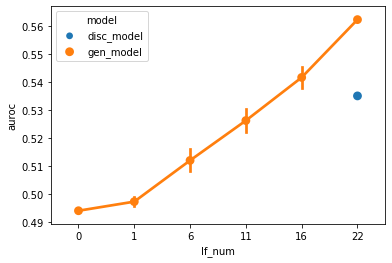

In [16]:
ax = sns.pointplot(
    x='lf_num', y='auroc',
    hue='model',
    data=dev_set_df,
    sd='ci'
)
for x_spot, lf_num in enumerate(sorted(dev_set_df.lf_num.unique())):
    print(lf_num)
    print(
        dev_set_df.query(f"lf_num=={lf_num}&model=='disc_model'").auroc.mean()-
        dev_set_df.query(f"lf_num=={lf_num}&model=='gen_model'").auroc.mean()
    )

0
nan
1
nan
6
nan
11
nan
16
nan
22
0.023346699182493158


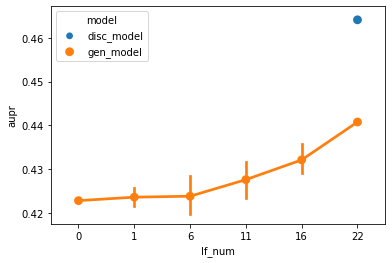

In [17]:
ax = sns.pointplot(
    x='lf_num', y='aupr',
    hue='model',
    data=dev_set_df,
    sd='ci'
)
for x_spot, lf_num in enumerate(sorted(dev_set_df.lf_num.unique())):
    print(lf_num)
    print(
        dev_set_df.query(f"lf_num=={lf_num}&model=='disc_model'").aupr.mean()-
        dev_set_df.query(f"lf_num=={lf_num}&model=='gen_model'").aupr.mean()
    )

# Test Set

In [18]:
test_labels = pd.read_csv("input/dag_test_labels.tsv", sep="\t")
test_labels.head()

,candidate_id,curated_dsh
0,23356,0.0
1,23367,1.0
2,23820,1.0
3,24815,0.0
4,80484,0.0


In [19]:
candidate_df = (
    pd.read_excel("../data/sentences/sentence_labels_test.xlsx")
    .sort_values("candidate_id")
    .query("curated_dsh.notnull()")
)
candidate_df.head()

,candidate_id,disease,gene,doid_id,entrez_gene_id,sentence,curated_dsh,notes_dsh,curated_dug,notes_dug,curated_ddg,notes_ddg
0,23356,extrinsic asthma,ACTH),DOID:2841,5443,hypothalamic-pituitary-adrenal function in a w...,0.0,NaN,0.0,NaN,0.0,NaN
1,23367,RA,GGTP,DOID:7148,92086,the values for ~~[[2 ggtp 2]]~~ were significa...,1.0,NaN,1.0,NaN,0.0,NaN
2,23820,hepatitis B,eAg),DOID:2043,3756,"a family of antigens , referred to collectivel...",1.0,NaN,0.0,NaN,0.0,NaN
3,24815,hepatoma,Mitochondrial ATPase,DOID:3571,514,~~[[2 mitochondrial atpase 2]]~~ activities of...,0.0,NaN,0.0,NaN,0.0,NaN
4,80484,hypertensive,fibrinogen,DOID:10763,2244,"the blood pressure , the plasma renin activity...",0.0,NaN,0.0,NaN,0.0,NaN


In [20]:
gen_model_results_test_df = pd.read_csv(
    "../label_sampling_experiment/results/CtD/results/test_sampled_results.tsv", 
    sep="\t"
)

In [22]:
disc_model_dict = {}

disc_model_dict['22'] = (
        pd.read_csv(f"input/neg/22/test.tsv", sep="\t")
)

In [23]:
records = []
for sample in disc_model_dict:
        for column in disc_model_dict[sample].drop("candidate_id", axis=1).columns:
            aucs = get_au_performance(
                disc_model_dict[sample][column],
                candidate_df
                .query(f"candidate_id in {disc_model_dict[sample].candidate_id.values.tolist()}")
                .curated_dsh
                .values
            )
            records.append({
                "model": "disc_model",
                "lf_num": int(sample),
                "auroc": aucs[0],
                "aupr": aucs[1]
            })

test_set_df = (
    pd.DataFrame.from_records(records)
    .append(
        gen_model_results_test_df
        .drop("lf_sample", axis=1)
        .assign(model="gen_model")
    )
)

0
nan
1
nan
6
nan
11
nan
16
nan
22
-0.03128196498015412


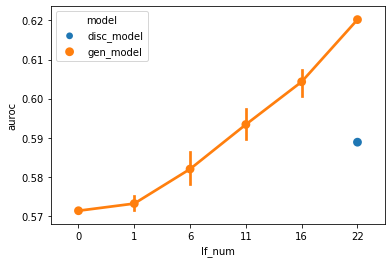

In [24]:
ax = sns.pointplot(
    x='lf_num', y='auroc',
    hue='model',
    data=test_set_df,
    sd='ci'
)
for x_spot, lf_num in enumerate(sorted(dev_set_df.lf_num.unique())):
    print(lf_num)
    print(
        test_set_df.query(f"lf_num=={lf_num}&model=='disc_model'").auroc.mean()-
        test_set_df.query(f"lf_num=={lf_num}&model=='gen_model'").auroc.mean()
    )

0
nan
1
nan
6
nan
11
nan
16
nan
22
0.013031057111188016


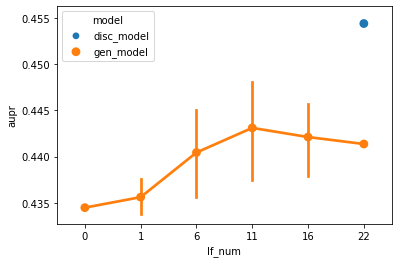

In [25]:
ax = sns.pointplot(
    x='lf_num', y='aupr',
    hue='model',
    data=test_set_df,
    sd='ci'
)
for x_spot, lf_num in enumerate(sorted(dev_set_df.lf_num.unique())):
    print(lf_num)
    print(
        test_set_df.query(f"lf_num=={lf_num}&model=='disc_model'").aupr.mean()-
        test_set_df.query(f"lf_num=={lf_num}&model=='gen_model'").aupr.mean()
    )